The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
!pip install -U mxnet-cu101==1.7.0


# 样式迁移

如果你是一位摄影爱好者，你也许接触过滤镜。它能改变照片的颜色样式，从而使风景照更加锐利或者令人像更加美白。但一个滤镜通常只能改变照片的某个方面。如果要照片达到理想中的样式，你可能需要尝试大量不同的组合。这个过程的复杂程度不亚于模型调参。 

在本节中，我们将介绍如何使用卷积神经网络，自动将一个图像中的样式应用在另一图像之上，即*样式迁移*（style transfer） :cite:`Gatys.Ecker.Bethge.2016`。
这里我们需要两张输入图像：一张是*内容图像*，另一张是*样式图像*。
我们将使用神经网络修改内容图像，使其在样式上接近样式图像。
例如， :numref:`fig_style_transfer` 中的内容图像为本书作者在西雅图郊区的雷尼尔山国家公园拍摄的风景照，而样式图像则是一幅主题为秋天橡树的油画。
最终输出的合成图像应用了样式图像的油画笔触让整体颜色更加鲜艳，同时保留了内容图像中物体主体的形状。

![输入内容图像和样式图像，输出样式迁移后的合成图像](../img/style-transfer.svg)
:label:`fig_style_transfer`

## 方法

:numref:`fig_style_transfer_model` 用简单的例子阐述了基于卷积神经网络的样式迁移方法。
首先，我们初始化合成图像，例如将其初始化为内容图像。
该合成图像是样式迁移过程中唯一需要更新的变量，即样式迁移所需迭代的模型参数。
然后，我们选择一个预训练的卷积神经网络来抽取图像的特征，其中的模型参数在训练中无须更新。
这个深度卷积神经网络凭借多个层逐级抽取图像的特征，我们可以选择其中某些层的输出作为内容特征或样式特征。
以 :numref:`fig_style_transfer_model` 为例，这里选取的预训练的神经网络含有3个卷积层，其中第二层输出内容特征，第一层和第三层输出样式特征。  

![基于卷积神经网络的样式迁移。实线箭头和虚线箭头分别表示正向传播和反向传播](../img/neural-style.svg)
:label:`fig_style_transfer_model`

接下来，我们通过正向传播（实线箭头方向）计算样式迁移的损失函数，并通过反向传播（虚线箭头方向）迭代模型参数，即不断更新合成图像。
样式迁移常用的损失函数由3部分组成：
(i) *内容损失*使合成图像与内容图像在内容特征上接近；
(ii) *样式损失*使合成图像与样式图像在样式特征上接近；
(iii) *总变差损失*则有助于减少合成图像中的噪点。
最后，当模型训练结束时，我们输出样式迁移的模型参数，即得到最终的合成图像。 

在下面，我们将通过代码来进一步了解样式迁移的技术细节。

## [**阅读内容和样式图像**]

首先，我们读取内容和样式图像。
从打印出的图像坐标轴可以看出，它们的尺寸并不一样。


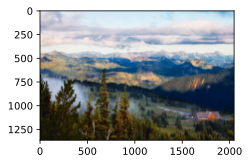

In [1]:
%matplotlib inline
from mxnet import autograd, gluon, image, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

d2l.set_figsize()
content_img = image.imread('../img/rainier.jpg')
d2l.plt.imshow(content_img.asnumpy());

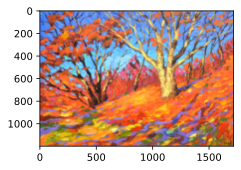

In [2]:
style_img = image.imread('../img/autumn-oak.jpg')
d2l.plt.imshow(style_img.asnumpy());

## [**预处理和后处理**]

下面，定义图像的预处理函数和后处理函数。
预处理函数`preprocess`对输入图像在RGB三个通道分别做标准化，并将结果变换成卷积神经网络接受的输入格式。
后处理函数`postprocess`则将输出图像中的像素值还原回标准化之前的值。
由于图像打印函数要求每个像素的浮点数值在0到1之间，我们对小于0和大于1的值分别取0和1。


In [3]:
rgb_mean = np.array([0.485, 0.456, 0.406])
rgb_std = np.array([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    return np.expand_dims(img.transpose(2, 0, 1), axis=0)

def postprocess(img):
    img = img[0].as_in_ctx(rgb_std.ctx)
    return (img.transpose(1, 2, 0) * rgb_std + rgb_mean).clip(0, 1)

## [**抽取图像特征**]

我们使用基于ImageNet数据集预训练的VGG-19模型来抽取图像特征 :cite:`Gatys.Ecker.Bethge.2016`。


In [4]:
pretrained_net = gluon.model_zoo.vision.vgg19(pretrained=True)

为了抽取图像的内容特征和样式特征，我们可以选择VGG网络中某些层的输出。
一般来说，越靠近输入层，越容易抽取图像的细节信息；反之，则越容易抽取图像的全局信息。
为了避免合成图像过多保留内容图像的细节，我们选择VGG较靠近输出的层，即*内容层*，来输出图像的内容特征。
我们还从VGG中选择不同层的输出来匹配局部和全局的样式，这些图层也称为*样式层*。
正如 :numref:`sec_vgg` 中所介绍的，VGG网络使用了5个卷积块。
实验中，我们选择第四卷积块的最后一个卷积层作为内容层，选择每个卷积块的第一个卷积层作为样式层。
这些层的索引可以通过打印`pretrained_net`实例获取。


In [5]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

使用VGG层抽取特征时，我们只需要用到从输入层到最靠近输出层的内容层或样式层之间的所有层。
下面构建一个新的网络`net`，它只保留需要用到的VGG的所有层。


In [6]:
net = nn.Sequential()
for i in range(max(content_layers + style_layers) + 1):
    net.add(pretrained_net.features[i])

给定输入`X`，如果我们简单地调用前向计算`net(X)`，只能获得最后一层的输出。
由于我们还需要中间层的输出，因此这里我们逐层计算，并保留内容层和样式层的输出。


In [7]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

下面定义两个函数：`get_contents`函数对内容图像抽取内容特征；
`get_styles`函数对样式图像抽取样式特征。
因为在训练时无须改变预训练的VGG的模型参数，所以我们可以在训练开始之前就提取出内容特征和样式特征。
由于合成图像是样式迁移所需迭代的模型参数，我们只能在训练过程中通过调用`extract_features`函数来抽取合成图像的内容特征和样式特征。


In [8]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).copyto(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).copyto(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## [**定义损失函数**]

下面我们来描述样式迁移的损失函数。
它由内容损失、样式损失和总变差损失3部分组成。 

### 内容损失

与线性回归中的损失函数类似，内容损失通过平方误差函数衡量合成图像与内容图像在内容特征上的差异。
平方误差函数的两个输入均为`extract_features`函数计算所得到的内容层的输出。


In [9]:
def content_loss(Y_hat, Y):
    return np.square(Y_hat - Y).mean()

### 样式损失

样式损失与内容损失类似，也通过平方误差函数衡量合成图像与样式图像在样式上的差异。
为了表达样式层输出的样式，我们先通过`extract_features`函数计算样式层的输出。
假设该输出的样本数为1，通道数为$c$，高和宽分别为$h$和$w$，我们可以将此输出转换为矩阵 $\mathbf{X}$，其有$c$行和$hw$列。
这个矩阵可以被看作是由$c$个长度为$hw$的向量$\mathbf{x}_1, \ldots, \mathbf{x}_c$组合而成的。其中向量$\mathbf{x}_i$代表了通道 $i$ 上的样式特征。  

在这些向量的*格拉姆矩阵* $\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{c \times c}$ 中，$i$ 行 $j$ 列的元素 $x_{ij}$ 即向量 $\mathbf{x}_i$ 和 $\mathbf{x}_j$ 的内积。它表达了通道 $i$ 和通道 $j$ 上样式特征的相关性。我们用这样的格拉姆矩阵来表达样式层输出的样式。
需要注意的是，当$hw$的值较大时，格拉姆矩阵中的元素容易出现较大的值。
此外，格拉姆矩阵的高和宽皆为通道数$c$。
为了让样式损失不受这些值的大小影响，下面定义的`gram`函数将格拉姆矩阵除以了矩阵中元素的个数，即 $chw$ 。


In [10]:
def gram(X):
    num_channels, n = X.shape[1], d2l.size(X) // X.shape[1]
    X = X.reshape((num_channels, n))
    return np.dot(X, X.T) / (num_channels * n)

自然地，样式损失的平方误差函数的两个格拉姆矩阵输入分别基于合成图像与样式图像的样式层输出。这里假设基于样式图像的格拉姆矩阵`gram_Y`已经预先计算好了。


In [11]:
def style_loss(Y_hat, gram_Y):
    return np.square(gram(Y_hat) - gram_Y).mean()

### 总变差损失

有时候，我们学到的合成图像里面有大量高频噪点，即有特别亮或者特别暗的颗粒像素。
一种常见的降噪方法是*总变差降噪*：
假设 $x_{i, j}$ 表示坐标 $(i, j)$ 处的像素值，降低总变差损失 

$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|$$

能够尽可能使邻近的像素值相似。


In [12]:
def tv_loss(Y_hat):
    return 0.5 * (np.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  np.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

### 损失函数

[**风格转移的损失函数是内容损失、风格损失和总变化损失的加权和**]。
通过调节这些权值超参数，我们可以权衡合成图像在保留内容、迁移样式以及降噪三方面的相对重要性。


In [13]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

## [**初始化合成图像**]

在样式迁移中，合成的图像是训练期间唯一需要更新的变量。因此，我们可以定义一个简单的模型 `SynthesizedImage`，并将合成的图像视为模型参数。模型的前向计算只需返回模型参数即可。


In [14]:
class SynthesizedImage(nn.Block):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=img_shape)

    def forward(self):
        return self.weight.data()

下面，我们定义 `get_inits` 函数。该函数创建了合成图像的模型实例，并将其初始化为图像 `X` 。样式图像在各个样式层的格拉姆矩阵 `styles_Y_gram` 将在训练前预先计算好。


In [15]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape)
    gen_img.initialize(init.Constant(X), ctx=device, force_reinit=True)
    trainer = gluon.Trainer(gen_img.collect_params(), 'adam',
                            {'learning_rate': lr})
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

## [**训练模型**]

在训练模型进行样式迁移时，我们不断抽取合成图像的内容特征和样式特征，然后计算损失函数。下面定义了训练循环。


In [16]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs], ylim=[0, 20],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        with autograd.record():
            contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
            contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step(1)
        if (epoch + 1) % lr_decay_epoch == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.8)
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X).asnumpy())
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

现在我们[**训练模型**]：
首先将内容图像和样式图像的高和宽分别调整为300和450像素，用内容图像来初始化合成图像。


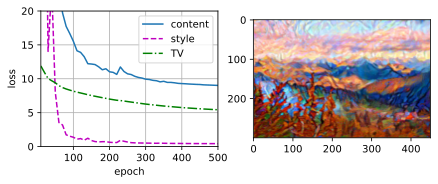

In [17]:
device, image_shape = d2l.try_gpu(), (450, 300)
net.collect_params().reset_ctx(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.9, 500, 50)

我们可以看到，合成图像保留了内容图像的风景和物体，并同时迁移了样式图像的色彩。例如，合成图像具有与样式图像中一样的色彩块，其中一些甚至具有画笔笔触的细微纹理。 

## 小结

* 样式迁移常用的损失函数由3部分组成：(i) 内容损失使合成图像与内容图像在内容特征上接近；(ii) 样式损失令合成图像与样式图像在样式特征上接近；(iii) 总变差损失则有助于减少合成图像中的噪点。
* 我们可以通过预训练的卷积神经网络来抽取图像的特征，并通过最小化损失函数来不断更新合成图像来作为模型参数。
* 我们使用格拉姆矩阵表达样式层输出的样式。

## 练习

1. 选择不同的内容和样式层，输出有什么变化？
1. 调整损失函数中的权值超参数。输出是否保留更多内容或减少更多噪点？
1. 替换实验中的内容图像和样式图像，你能创作出更有趣的合成图像吗？
1. 我们可以对文本使用样式迁移吗？提示:你可以参阅调查报告 :cite:`Hu.Lee.Aggarwal.2020`。


[Discussions](https://discuss.d2l.ai/t/3299)
